## LISTA
Utilizes code from crino module. Run notebook with --pylab switch.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import gzip, cPickle
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib

Using gpu device 0: GeForce GTX 580


In [2]:
from osdfutils import crino
from osdfutils import misc

In [3]:
# uncomment next two lines if inline plotting should be enabled.
%matplotlib inline
#matplotlib.rcParams['savefig.dpi'] = 144

In [4]:
# needs local mnist.pkl.gz
mnist_f = gzip.open("mnist.pkl.gz",'rb')                              
train_set, valid_set, test_set = cPickle.load(mnist_f)                
data = train_set[0]
dm = data.mean(axis=0)
# normalize
data = data - dm
trgts = train_set[1]
valid = (valid_set[0] - dm)
mnist_f.close()

In [5]:
%load_ext autoreload
%autoreload 2
reload(crino)

<module 'osdfutils.crino' from '/home/osendorf/proj/utils/osdfutils/crino.pyc'>

In [ ]:
epochs = 20
btsz = 100
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LISTA -- Learned ISTA without ISTA"
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, 28*28), "variant": "normal", "std": 0.1}

lmbd = 1 # sparsity weight
L = 1.
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 1e-2}}

x, params, cost, rec, z = crino.lista(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(misc.visualize(params[0].get_value(), 28*28))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
# show me the money
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = (reconstructor(valid[:14*14])*dstd)+dm
im = np.array(misc.visualize(recs, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

In [ ]:
plt.hist(sp.ravel(), bins=100, normed=True)

## Learned CoD

In [ ]:
reload(crino)
epochs = 20
btsz = 100
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LCoD -- Learned CoD without coordinate descent"
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, 28*28), "variant": "normal", "std": 0.1}

lmbd = 1 # sparsity weight
L = 1.
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 0.5}}

x, params, cost, rec, z = crino.lcod(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(misc.visualize(params[0].get_value(), 28*28))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(valid[:14*14]) + dm
im = np.array(misc.visualize(recs, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
%matplotlib inline
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

In [ ]:
plt.hist(sp.ravel(), bins=100, normed=True)

##LConvISTA

In [ ]:
reload(crino)
epochs = 20
btsz = 100
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LeConISTA -- Learned Convolutional ISTA"
print "Epochs", epochs
print "Batches per epoch", batches
print

dx, dy = 28, 28
lmbd = 1 # sparsity weight
L = 1.
layers = 10
filters = 16
filter_sz = 5
theta = 0.001
Dinit = {"shape": (filters, filter_sz**2), "variant": "normal", "std": 0.1, "tensor": (1, filters, filter_sz, filter_sz)}
imshape = (btsz, 1, dx, dy)
zshape = (btsz, filters, dx + filter_sz - 1, dy + filter_sz - 1)
config = {"btsz": btsz, "D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "theta": theta, "imshape": imshape, "zshape": zshape}
# normalize weights according to this config
norm_dic = {"D": {"axis":[2, 3], "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 1e-10}}

x, params, z, rec, rec_err, cost, sparsity = crino.lconvista(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
#updates = crino.norm_updt(params, updates, todo=norm_dic)
updates[params[0]] = updates[params[0]] / T.sqrt(theano.map(lambda patch: (patch**2).sum(keepdims=True),updates[params[0]][0])[0])

# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

### Experiment

In [13]:
reload(crino)
epochs = 20
btsz = 100
lr = 1
momentum = 0.1
decay = 0.95
batches = data.shape[0]/btsz
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, data.shape[1]), "variant": "normal", "std": 0.1}
Qinit = {"shape": (sparse_shape, sparse_shape), "variant": "normal", "std": 0.1}
lmbd = 1. # sparsity weight
L = 1.
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "Q": Qinit}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}
            ,"Q": {"axis":1, "c": 1.}
            ,"W": {"axis":0, "c":1.}}
# non-diagonals should be at most 0
#thresh_dic = {"Q": {"thresh": 0}}

x, params, cost, rec, z = crino.lode(config=config, activ=T.tanh, tied=True)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adam(params, grads, settings)#, **norm_dic)
# ... normalize weights
for p in params:
    if p.name == "Q":
        qupdt = updates[p]
        qdiag = T.diag(qupdt)
        qrest = qupdt - T.diag(qdiag)
        #qdiag = T.maximum(0, qdiag)
        qdiag = 0*T.diag(qdiag)
        qrest = T.minimum(0, qrest)
        updates[p] = qdiag + qrest

updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
#updates = crino.min_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

Epochs 20
Batches per epoch 500

[LODE]
[AdaM] alpha: 0.0002; beta1: 0.1, beta2: 0.001, lambda: 1e-08
[NORM_UPDT] D normalized to 1.0 along axis 1
[NORM_UPDT] Q normalized to 1.0 along axis 1
done.


In [10]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

0 75.2220806274
1 37.0872646332
2 33.2539721031
3 31.5850502739
4 30.4611757164
5 29.7558717499
6 29.3564589615
7 29.0697678299
8 28.8116074829
9 28.5420414009
10 28.3012211227
11 28.1277037163
12 27.9627987022
13 27.7902682114
14 27.6250596313
15 27.4651787415
16 27.3207132759
17 27.21545047
18 27.1133001595
19 27.0211515808


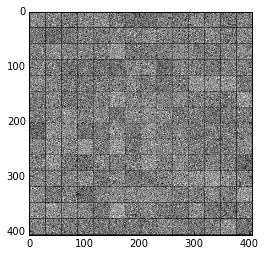

In [14]:
im = np.array(misc.visualize(params[0].get_value(), data.shape[1]))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

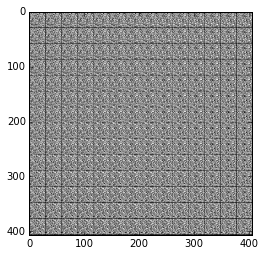

In [15]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(data[:14*14])
im = np.array(misc.visualize(recs, data.shape[1]))
plt.imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(misc.visualize(valid[:14*14]+dm, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
%matplotlib inline
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

In [ ]:
plt.hist(sp.ravel(), bins=100, normed=True)

In [ ]:
params[1].get_value()

In [ ]:
im = np.array(misc.visualize(params[1].get_value(), 14*14))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('Q.png')

In [ ]:
params[3].get_value()

In [ ]:
params[2].get_value()

In [ ]:
from cifar10 import dataset as ds
data = ds.get_store("cifar10_gray_32x32.h5")
tmp = np.asarray(data['train']['inputs'], dtype=np.float)
tmp = tmp - tmp.mean(axis=1, keepdims=True)
tmp = tmp/(tmp.std(axis=1, keepdims=True) + 1e-6)

In [ ]:
im = np.array(misc.visualize(tmp[:100], 32**2))
plt.imshow(im, cmap=cm.gray)

In [ ]:
data = tmp

In [ ]:
data.shape

In [ ]:
reload(crino)
epochs = 20
btsz = 100
lr = 1
momentum = 0.1
decay = 0.95
batches = data.shape[0]/btsz
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape = 40
Dinit = {"shape": (1, sparse_shape, 15, 15), "variant": "uniform", "std": 0.1}
Qinit = {"shape": (sparse_shape, sparse_shape, 1, 1), "variant": "normal", "std": 0.1}
Winit = {"shape": (sparse_shape, 1, 15, 15), "variant": "uniform", "std": 0.1}
imshape = (btsz, 1, 28, 28)
lmbd = 0.00001 # sparsity weight
L = 1
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "Q": Qinit, "W": Winit,
          "imshape": imshape}
# normalize weights according to this config
norm_dic = {"D": {"axis": (2,3), "c": 1.}
            ,"Q": {"axis":(1, 2, 3), "c": 1.}
            ,"W": {"axis": (2,3), "c":1.}}
# non-diagonals should be at most 0
#thresh_dic = {"Q": {"thresh": 0}}

x, params, cost, rec, z = crino.lodeconv(config=config, activ=T.tanh, tied=False)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
for p in params:
    if p.name == "Q":
        qupdt = updates[p]
        qupdt = qupdt.flatten(ndim=2)
        qdiag = T.diag(qupdt)
        qrest = qupdt - T.diag(qdiag)
        qdiag = T.diag(T.maximum(0, qdiag))
        #qdiag = 0.*T.diag(qdiag)
        qrest = T.minimum(0, qrest)
        qupdt = qdiag + qrest
        qupdt = qupdt.reshape(updates[p].shape)
        updates[p] = qupdt

updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
#updates = crino.min_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz].reshape(100, 1, 28, 28))
    print epoch, cost/sz

In [ ]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(data[:10*10].reshape(100, 1, 28, 28))
im = np.array(misc.visualize(recs, data.shape[1], fill=255))
plt.imshow(im, cmap=cm.gray)

In [ ]:
((params[-1].get_value()))

In [ ]:
im = np.array(misc.visualize(params[0].get_value().reshape(40, 225), 225, fill=255))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
params[1].get_value()